In [1]:
import os
import sys
import json
import PIL
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

In [23]:
from augmentation import Image as Augment #Source Code Not Provided

In [3]:
SAMPLES_PER_IMAGE = 50
SOURCE_PATH = f'../data/images_handheld'
TARGET_PATH = f'../data/dataset'
ANNOTATIONS = f'../data/annotations_handheld.csv'
OUTPUT_SHAPE = (608, 608) #(height, width) - 608 default for YoloV4
GEO_METHODS   = ['crop', 'rotate', 'flip', 'scale']
PHOTO_METHODS = ['brighten', 'sharpen', 'contrast', 'noise'] #Photometric methods

In [4]:
def bbox_to_roi(bbox):
    """
        Converts bounding box coordinates given in
        [(x1, y2), (x2, y2)] format and returns 
        [(top left y, top left x), (bottom right y, bottom right x)]
        
        The reasoning being that the annotations provided by Mohatney et al. are not uniform in their layout.
    """
    y2, y1 = bbox[1][1],  bbox[0][1]
    x2, x1 = bbox[1][0], bbox[0][0]
    
    roi = None
    if y2 >= y1:
        if x2 >= x1: #top left, bottom right
            roi = [(y1, x1), (y2, x2)]
        else: #Top right, bottom left
            height = y2 - y1
            roi = [(y2-height, x2), (y1+height, x1)]
    else:
        if x2 >= x1: #Bottom left, top_right
            height = y1-y2
            roi = [(y1-height, x1), (y2+height, x2)]
        else: #bottom right, top left
            roi = [(y2, x2), (y1, x1)]
        
    return roi

# Read annotations

In [5]:
anns = pd.read_csv(ANNOTATIONS)

## Remove images that contain more than one instance of NCLB

In [6]:
vcs = anns['image'].value_counts().to_frame().rename(columns={'image': 'counts'})

In [7]:
vcs = vcs[vcs.counts > 1]

In [8]:
anns = anns[~anns['image'].isin(list(vcs.index))]

In [9]:
anns

,image,x1,y1,x2,y2,user,day,month,year,hour,minute
0,DSC00025.JPG,1864,2064,2864,1648,Tyr,26,5,2016,16,48
1,DSC00026.JPG,2872,1416,3152,2016,Tyr,26,5,2016,16,48
2,DSC00027.JPG,0,0,0,0,Tyr,5,10,2015,17,0
5,DSC00029.JPG,0,0,0,0,Tyr,5,10,2015,17,0
6,DSC00030.JPG,0,0,0,0,Tyr,5,10,2015,17,0
...,...,...,...,...,...,...,...,...,...,...,...
7665,IMG_6746.Jpeg,0,0,0,0,Tyr,5,10,2015,16,49
7678,IMG_6751.Jpeg,3156,1284,1824,1368,Tyr,4,4,2016,17,5
7679,IMG_6752.Jpeg,0,0,0,0,Tyr,5,10,2015,16,49
7680,IMG_6753.Jpeg,0,0,0,0,Tyr,5,10,2015,16,59


## Remove images without an annotation

In [10]:
rois = []
image_names = []

eligible = set(os.listdir(SOURCE_PATH))
for i in range(len(anns.index)):
    row = anns.iloc[i]
    
    name = row['image']
    if name in eligible:
        bbox = [(row['x1'], row['y1']), (row['x2'], row['y2'])]
        roi = bbox_to_roi(bbox)
        if roi != [(0,0), (0,0)]:
            rois.append(roi)
            image_names.append(SOURCE_PATH+'/'+name)

In [11]:
print(len(eligible))
print(len(rois))
print(len(image_names))

1787
139
139


## View sample image to verify region of interest (ROI) location is correct

In [14]:
index = 0
with PIL.Image.open(image_names[index]) as im:
    draw = PIL.ImageDraw.Draw(im)
    roi = rois[index]
    y0, x0, y1, x1 = (roi[0] + roi[1])
    draw.rectangle([x0, y0, x1, y1], outline='red', width=5)
    im.show()

# Augment images to create additional samples

In [22]:
def augment_image(filename, roi, target_shape=(608, 608)):
    """
        Perform photometric and geomtric augmentations on an image to create a new sample
    """
    image = Augment().load(filename)
    image.geomorphic_methods  = GEO_METHODS
    image.photometric_methods = PHOTO_METHODS
    image.assign_roi(roi)
    
    image.geo_distort()
    image.photo_distort()
    image.resize(target_shape)
    
    return image 

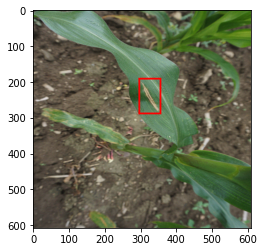

In [24]:
im = augment_image(image_names[index], rois[index])
im.draw_roi(color='red', width=5)
im.show()

In [27]:
def gen_dataset():
    for i, name in enumerate(image_names):
        roi = rois[i]
        for j in range(SAMPLES_PER_IMAGE):
            yield augment_image(name, roi, OUTPUT_SHAPE)

# Generate Dataset

In [ ]:
#Perform augmentations and generate roughly 7000 samples
####This block of code takes roughly 3 hours to complete.#####
i = 1
updated_rois = {}
print('IMG COUNT:', SAMPLES_PER_IMAGE*len(image_names))
for image in gen_dataset():
    print('Image Num:', i, '\r', end='')
    sys.stdout.flush()
    img_num = str(i)
    filename = '00000000'[:-len(img_num)] + img_num + '.jpg'
    updated_rois[filename] = image.roi.tolist()
    image.save(TARGET_PATH+'/images/'+filename)
    i += 1

## Save annotations

In [30]:
with open(TARGET_PATH + '/annotations.json', 'w+') as f:
    json.dump(updated_rois, f)

# Convert to YoloV4 format

In [31]:
from augmentation import Image
def convert(filename_str, coords):
    """
        function that turns XMin, YMin, XMax, YMax coordinates to normalized yolo format
    """
    CLASS_ID = 0
    image = PIL.Image.open(f'{TARGET_PATH}/images/{filename_str}')
    image = np.asarray(image)
    coords[2] -= coords[0]
    coords[3] -= coords[1]
    x_diff = int(coords[2]/2)
    y_diff = int(coords[3]/2)
    coords[0] = coords[0]+x_diff
    coords[1] = coords[1]+y_diff
    coords[0] /= int(image.shape[1])
    coords[1] /= int(image.shape[0])
    coords[2] /= int(image.shape[1])
    coords[3] /= int(image.shape[0])
    return [CLASS_ID] + coords

In [46]:
convert('00000001.jpg', [522, 638, 634, 685])

[0,
 0.9506578947368421,
 1.087171052631579,
 0.18421052631578946,
 0.07730263157894737]

In [32]:
TARGET_PATH

'../data/dataset'

In [33]:
with open(TARGET_PATH+'/annotations.json', 'r') as f:
    obj = json.load(f)

## Create .txt file to accompany each image file

In [34]:
for key in tqdm(obj):
    coords = obj[key]
    ymin, xmin = coords[0]
    ymax, xmax = coords[1]
    new_coords = convert(key, [xmin, ymin, xmax, ymax])
    with open(TARGET_PATH+'/images/' + key[:-3]+'txt', 'w+') as f:
        f.write(' '.join(map(str, new_coords)))

100%|██████████| 31/31 [00:00<00:00, 182.74it/s]


# Train/Test Split

In [39]:
TEST_PATH  = '../data/test'
TRAIN_PATH = '../data/train'

In [46]:
Path(TRAIN_PATH).mkdir(exist_ok=False)
Path(TEST_PATH).mkdir(exist_ok=False)

In [47]:
img_names = [
    '00000000'[:-len(str(img_num+1))] + str(img_num+1) + '.jpg'
    for img_num in 
    range(int(len(os.listdir(TARGET_PATH+'/images'))/2))
]

In [48]:
train = []
test  = []

train_perc = 0.8
split = int(train_perc*SAMPLES_PER_IMAGE)
for i, name in enumerate(img_names):
    if i % (SAMPLES_PER_IMAGE) > split:
        print(i, name)
        test.append(name)
    else:
        train.append(name)

In [49]:
for name in train:
    txt_file = name[:-3]+'txt'
    Path(TARGET_PATH+'/images/'+name).rename(Path(TRAIN_PATH+'/'+name)) #move image
    Path(TARGET_PATH+'/images/'+txt_file).rename(Path(TRAIN_PATH+'/'+txt_file)) #move txt file

In [61]:
for name in test:
    txt_file = name[:-3]+'txt'
    Path(TARGET_PATH+'/images/'+name).rename(Path(TEST_PATH+'/'+name)) #Moce image
    Path(TARGET_PATH+'/images/'+txt_file).rename(Path(TEST_PATH+'/'+txt_file)) #Move txt file